In [2]:
# !pip uninstall torch-geometric -y
# !pip uninstall torch-scatter -y
# !pip uninstall torch-sparse -y

# # Install necessary dependencies
# !pip install torch-scatter 
# !pip install torch-sparse 

# # Install torch-geometric
# !pip install torch-geometric 


Found existing installation: torch-geometric 2.6.1
Uninstalling torch-geometric-2.6.1:
  Successfully uninstalled torch-geometric-2.6.1
  Using cached torch_scatter-2.1.2.tar.gz (108 kB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [45 lines of output]
      Compiling without OpenMP...
      Compiling without OpenMP...
      Compiling without OpenMP...
      Compiling without OpenMP...
      running bdist_wheel
      running build
      running build_py
      creating build/lib.macosx-10.15-x86_64-cpython-38/torch_scatter
      copying torch_scatter/placeholder.py -> build/lib.macosx-10.15-x86_64-cpython-38/torch_scatter
      copying torch_scatter/__init__.py -> build/lib.macosx-10.15-x86_64-cpython-38/torch_scatter
      copying torch_scatter/segment_csr.py -> build/lib.macosx-10.15-x86_64-cpython-38/torch_scatter
      copying torch_scatter/segment_coo.py -> build/li

In [3]:
from torch_geometric.utils import train_test_split_edges, to_networkx

/Users/kinakim/opt/anaconda3/envs/newenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from torch_geometric.datasets import TUDataset

# Mutag dataset
dataset = TUDataset(root='/tmp/MUTAG', name='MUTAG')

# Total the number of graphs
print(f"Number of graphs in the dataset: {len(dataset)}")

# Access individual graphs
for i, data in enumerate(dataset[:30]):  # analyze first 5 graphs
    print(f"\nGraph {i}:")
    print(f"Number of nodes: {data.num_nodes}")
    print(f"Number of edges: {data.num_edges}")
    print(f"Node feature matrix shape: {data.x.shape}")
    print(f"Edge index shape: {data.edge_index.shape}")
    print(f"Label: {data.y.item()}")

print(len(dataset))


Processing...


Number of graphs in the dataset: 188

Graph 0:
Number of nodes: 17
Number of edges: 38
Node feature matrix shape: torch.Size([17, 7])
Edge index shape: torch.Size([2, 38])
Label: 1

Graph 1:
Number of nodes: 13
Number of edges: 28
Node feature matrix shape: torch.Size([13, 7])
Edge index shape: torch.Size([2, 28])
Label: 0

Graph 2:
Number of nodes: 13
Number of edges: 28
Node feature matrix shape: torch.Size([13, 7])
Edge index shape: torch.Size([2, 28])
Label: 0

Graph 3:
Number of nodes: 19
Number of edges: 44
Node feature matrix shape: torch.Size([19, 7])
Edge index shape: torch.Size([2, 44])
Label: 1

Graph 4:
Number of nodes: 11
Number of edges: 22
Node feature matrix shape: torch.Size([11, 7])
Edge index shape: torch.Size([2, 22])
Label: 0

Graph 5:
Number of nodes: 28
Number of edges: 62
Node feature matrix shape: torch.Size([28, 7])
Edge index shape: torch.Size([2, 62])
Label: 1

Graph 6:
Number of nodes: 16
Number of edges: 34
Node feature matrix shape: torch.Size([16, 7])
Ed

Done!


In [5]:
import torch

# what are the labels?

all_labels = [data.y.item() for data in dataset]  
unique_classes = torch.unique(torch.tensor(all_labels))

print(f"Classes in the dataset: {unique_classes}")
print(f"Number of unique classes: {len(unique_classes)}")


Classes in the dataset: tensor([0, 1])
Number of unique classes: 2


In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, global_max_pool

class GNN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, num_classes):
        super(GNN, self).__init__()
        # Define the GCN layers
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels*2)
        self.conv3 = GCNConv(hidden_channels*2, hidden_channels)
        self.fc = nn.Linear(hidden_channels, num_classes)
        self.dropout = nn.Dropout(p=0.6)  
        self.bn1 = nn.BatchNorm1d(hidden_channels)
        self.bn2 = nn.BatchNorm1d(hidden_channels * 2)
        self.bn3 = nn.BatchNorm1d(hidden_channels)

        

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # Node-level embedding using GCN layers
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.dropout(x)  # Apply dropout after activation

        x = self.conv2(x, edge_index)
        x = F.relu(x)  
        x = self.bn2(x)
        x = self.dropout(x)  # Apply dropout after activation

        x = self.conv3(x, edge_index)  # Pass through the third GCN layer
        x = F.relu(x)  # Activation function after the third conv layer
        x = self.bn3(x)
        x = self.dropout(x)  # Apply dropout after activation
        
        # Graph-level embedding using mean pooling
        x = global_mean_pool(x, batch)  # Pool over all nodes in the graph
        # global_mean_pool
        
        # Apply a fully connected layer for classification
        x = self.fc(x)
        
        return x


Epoch 001 | Train Loss: 0.6648, Train Acc: 0.5933 | Val Loss: 0.6459, Val Acc: 0.7000
Epoch 002 | Train Loss: 0.6073, Train Acc: 0.7267 | Val Loss: 0.6115, Val Acc: 0.7000
Epoch 003 | Train Loss: 0.5903, Train Acc: 0.7333 | Val Loss: 0.5997, Val Acc: 0.7000
Epoch 004 | Train Loss: 0.5883, Train Acc: 0.7267 | Val Loss: 0.6008, Val Acc: 0.7000
Epoch 005 | Train Loss: 0.5395, Train Acc: 0.7467 | Val Loss: 0.6109, Val Acc: 0.7000
Epoch 006 | Train Loss: 0.5636, Train Acc: 0.7333 | Val Loss: 0.6263, Val Acc: 0.7000
Epoch 007 | Train Loss: 0.5633, Train Acc: 0.7400 | Val Loss: 0.6317, Val Acc: 0.7000
Epoch 008 | Train Loss: 0.5457, Train Acc: 0.7267 | Val Loss: 0.6213, Val Acc: 0.7000
Epoch 009 | Train Loss: 0.5915, Train Acc: 0.7067 | Val Loss: 0.6069, Val Acc: 0.7000
Epoch 010 | Train Loss: 0.5936, Train Acc: 0.7200 | Val Loss: 0.5871, Val Acc: 0.7000
Epoch 011 | Train Loss: 0.5270, Train Acc: 0.7533 | Val Loss: 0.5625, Val Acc: 0.7000
Epoch 012 | Train Loss: 0.5258, Train Acc: 0.7333 | Va

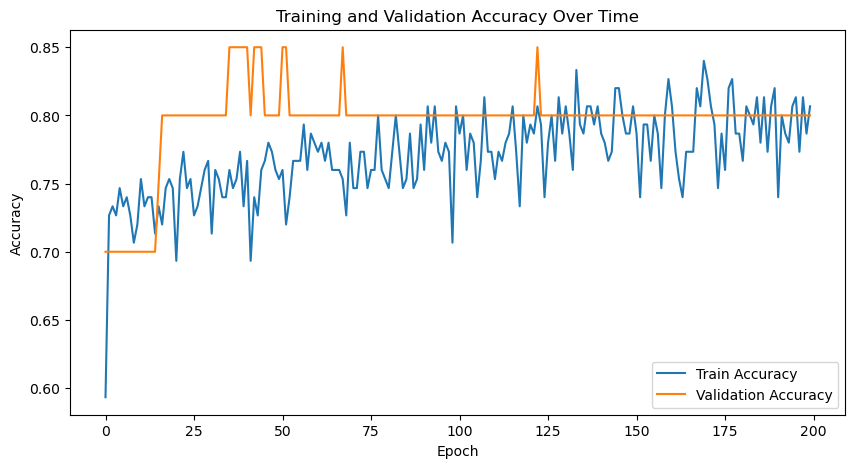

In [23]:
import torch.optim as optim
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt

# Shuffle and split the dataset: 60% train, 20% validation, 20% test
torch.manual_seed(42)
dataset = dataset.shuffle()
train_dataset = dataset[:150]      # First 150 graphs for training
val_dataset = dataset[150:170]     # Next 20 graphs for validation
test_dataset = dataset[170:]       # Remaining graphs for testing

# DataLoaders for each split
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model, optimizer, and loss function
model = GNN(num_node_features=dataset.num_node_features, hidden_channels=128, num_classes=2)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)  # Try lowering the learning rate, add weight_decay to help regularize the model and prevent overfitting to the training set.
criterion = nn.CrossEntropyLoss()

# Training loop
def train():
    model.train()
    total_loss = 0
    correct = 0
    for data in train_loader:  # Iterate over batches
        optimizer.zero_grad()
        out = model(data)  # Forward pass
        loss = criterion(out, data.y)  # Calculate loss
        total_loss += loss.item()
        loss.backward()  # Backpropagation
        optimizer.step()  # Update parameters

        pred = out.argmax(dim=1)  # Get the predictions
        correct += int((pred == data.y).sum())  # Check against labels

    accuracy = correct / len(train_loader.dataset)
    return total_loss / len(train_loader), accuracy

# Validation/test loop
def evaluate(loader):
    model.eval()
    total_loss = 0
    correct = 0
    for data in loader:
        out = model(data)
        loss = criterion(out, data.y)
        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())

    accuracy = correct / len(loader.dataset)
    return total_loss / len(loader), accuracy

# Lists to store losses and accuracies for plotting
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training process with validation
for epoch in range(1, 201):  # Train for 200 epochs
    train_loss, train_acc = train()
    val_loss, val_acc = evaluate(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f'Epoch {epoch:03d} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

# Plotting the training and validation accuracy over time
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Time')
plt.legend()
plt.show()
